# Test and run offline eval for comparison to ground truth values

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from skimage.morphology import skeletonize
from skimage import img_as_ubyte

In [54]:
def skeleton(mask):
    skeleton = skeletonize(mask)
    return skeleton
    
def skeleton_length(mask):
    skeleton_length = np.sum(skeletonize(mask))
    return skeleton_length

In [9]:
def process_skeleton_lengths(root_predictions, pred_files):
   
    data = []  # store rows for df

    for file in pred_files:
        mask_path = os.path.join(root_predictions, file) # full path 
        mask = Image.open(mask_path)
        mask = np.array(mask)

        skeleton_TL = skeleton_length(mask) # extract skeleton
        image_name = file.replace('pred_', '').replace('.png', '.JPG') # revert image name
        data.append((image_name, skeleton_TL)) # append tuple 
    
    df = pd.DataFrame(data, columns=['filename', 'skeleton_TL']) # construct df
        
    return(df)

In [34]:
# import predictions
root_predictions = '/home/Alexandra/Projects/bodycondition/sharkbody_seg/runs/unet_smp/split_crop/checkpoints/predictions'
pred_files = [f for f in os.listdir(root_predictions) if f.startswith("pred_")]
img_files = [f for f in os.listdir(root_predictions) if f.startswith("img_")]

# import metadata
metadata = '/mnt/class_data/group2/alexandradigiacomo/dataset/metadata/metadata.csv'
metadata_l = '/mnt/class_data/group2/alexandradigiacomo/dataset/metadata/sharklengths_metadata.csv'

df_meta = pd.read_csv(metadata)
df_meta_l = pd.read_csv(metadata_l)
df_meta_l.rename(columns={'FileName': 'filename'}, inplace=True)

df_meta_full = pd.merge(df_meta_l, df_meta, on=['filename', 'White.Shark.ID'], how='left')

In [35]:
# build skeleton df
df_skel = process_skeleton_lengths(root_predictions, pred_files)

In [ ]:
# merge skeleton with metadata
merged_df = pd.merge(df_skel, df_meta_full, on='filename', how='left')

In [5]:
# build masks list
masks = []
for file in pred_files:
    mask_path = os.path.join(root_predictions, file)
    mask = Image.open(mask_path)
    mask = np.array(mask)
    masks.append(mask)  

# build image list
imgs = []
for file in img_files:
    img_path = os.path.join(root_predictions, file)
    img = Image.open(img_path)
    img = np.array(img)
    imgs.append(img)


Sanity check plot

In [55]:
mask = masks[1] # pull mask
skeleton = skeleton(mask) # skeletonize mask

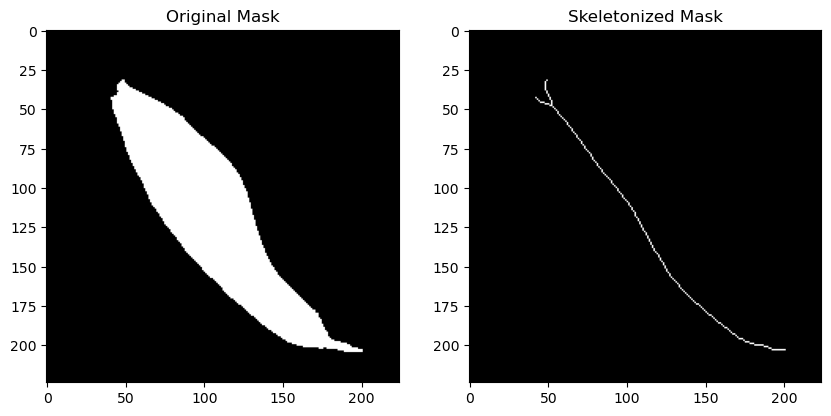

In [56]:
# Example plotting 
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Mask')
plt.imshow(mask, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Skeletonized Mask')
plt.imshow(skeleton, cmap='gray')

plt.show()

Compute TLs and Compare

In [39]:
# create col with transf pixels (this is hard coded currently)
crop_size = 512
mask_size = 224 

merged_df['TL_pixels_skeleton_transf'] = merged_df['skeleton_TL'] * (512 / 224)

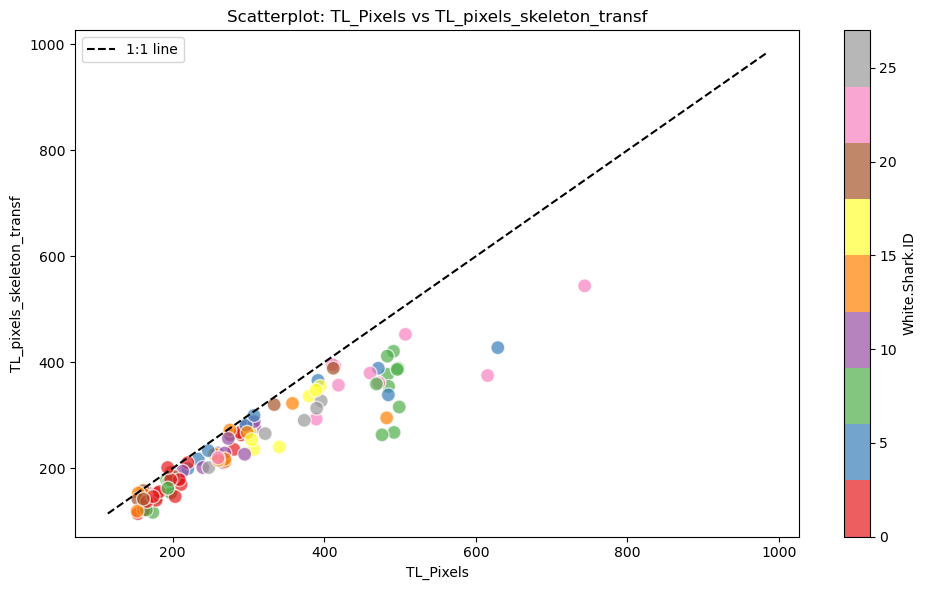

In [43]:
# Create a mapping of White.Shark.ID to numeric values
white_shark_id_mapping = {id_: idx for idx, id_ in enumerate(merged_df['White.Shark.ID'].unique())}
merged_df['White.Shark.ID_numeric'] = merged_df['White.Shark.ID'].map(white_shark_id_mapping)

# Create scatter plot with color mapping based on White.Shark.ID_numeric
plt.figure(figsize=(10, 6))

# Plot the scatter points, color by the numeric encoded White.Shark.ID
scatter = plt.scatter(merged_df['TL_Pixels'], merged_df['TL_pixels_skeleton_transf'],
                      c=merged_df['White.Shark.ID_numeric'], cmap='Set1', s=100, edgecolor='w', alpha=0.7)

# Plot the 1:1 line (where x = y)
min_val = min(merged_df['TL_Pixels'].min(), merged_df['TL_pixels_skeleton_transf'].min())
max_val = max(merged_df['TL_Pixels'].max(), merged_df['TL_pixels_skeleton_transf'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='k', linestyle='--', label='1:1 line')

# Add labels and title
plt.xlabel('TL_Pixels')
plt.ylabel('TL_pixels_skeleton_transf')
plt.title('Scatterplot: TL_Pixels vs TL_pixels_skeleton_transf')

# Add a colorbar and legend
plt.colorbar(scatter, label='White.Shark.ID')
plt.legend(loc='upper left')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


In [ ]:
merged_df['abs_resid'] = (merged_df['TL_Pixels'] - merged_df['TL_pixels_skeleton_transf']).abs()

In [47]:
# most extreme differences
top_residuals = merged_df.nlargest(10, 'abs_resid')
top_residuals

,filename,skeleton_TL,Label,White.Shark.ID,Nickname,TrueLength_ft,VisualLength_Ft,TL_Pixels,LateralSpan_Pixels,FrontalSpan_Pixels,...,GimbalPitchDegree,FlightRollDegree,FlightYawDegree,FlightPitchDegree,site,date,TL_pixels_skeleton_transf,White.Shark.ID_numeric,resid,abs_resid
50,12132023PAMB1002.JPG,164,shark,MB23121302_U_9,NaN,NaN,NaN,615.467,109.731,117.924,...,-90.0,-3.0,139.4,5.0,MB,12/13/2023,374.857143,21,240.609857,240.609857
42,10132023PAAN0105.JPG,117,shark,AN23101301_M_12,NaN,NaN,NaN,491.940,77.878,83.863,...,-90.0,-1.7,51.7,0.5,AN,10/13/2023,267.428571,6,224.511429,224.511429
84,10132023PAAN0104.JPG,115,shark,AN23101301_M_12,NaN,NaN,NaN,476.123,74.250,73.410,...,-89.9,-6.4,31.5,-3.2,AN,10/13/2023,262.857143,6,213.265857,213.265857
115,10132023PAAN0507.JPG,187,shark,AN23101304_U_U,NaN,NaN,NaN,628.892,115.135,118.072,...,-90.0,-6.4,17.0,-2.4,AN,10/13/2023,427.428571,5,201.463429,201.463429
149,12132023PAMB1003.JPG,238,shark,MB23121302_U_9,NaN,NaN,NaN,743.494,128.156,131.590,...,-89.9,3.6,174.5,2.7,MB,12/13/2023,544.000000,21,199.494000,199.494000
168,10072023PAMB0306.JPG,129,shark,MB23100702_U_8.5,NaN,NaN,NaN,482.218,78.230,80.262,...,-90.0,-0.4,42.9,-1.9,MB,10/07/2023,294.857143,13,187.360857,187.360857
65,10132023PAAN0109.JPG,138,shark,AN23101301_M_12,NaN,NaN,NaN,498.800,75.000,78.160,...,-89.9,5.4,-153.5,13.8,AN,10/13/2023,315.428571,6,183.371429,183.371429
90,10132023PAAN0508.JPG,148,shark,AN23101304_U_U,NaN,NaN,NaN,484.410,77.233,81.099,...,-90.0,-3.8,-23.2,-1.3,AN,10/13/2023,338.285714,5,146.124286,146.124286
26,10132023PAAN0107.JPG,155,shark,AN23101301_M_12,NaN,NaN,NaN,484.775,75.286,79.246,...,-89.9,2.0,-0.9,-24.4,AN,10/13/2023,354.285714,6,130.489286,130.489286
63,09232023PAMB0603.JPG,158,shark,MB23092308_F_9,NaN,NaN,NaN,471.884,82.462,81.688,...,-89.9,-25.0,-62.0,-7.0,MB,09/23/2023,361.142857,22,110.741143,110.741143
